In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
import csv
import sklearn.metrics
import numpy as np
import pandas as pd
from scipy import stats as stat
from gtfparse import read_gtf
from collections import OrderedDict

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = '../simulated_bulk_analysis/report_data'
sample_id = 'truncated_bulk_rnaseq'

## Helper functions (preparing data)

In [4]:
def getFiles(path, dataType):
    """
    Identify GTFs and count files in a directory.
    - dataType: a string, either 'sample' or 'reference'.
    """
    gtfList, countList = [], []
    for x in os.listdir(path):
        if x.endswith('.gtf'):
            gtf = path + x
            gtfList.append(gtf)
        if x.endswith('.tsv'):
            count = path + x
            countList.append(count)

    gtfList = sorted(gtfList)
    countList = sorted(countList)
    if dataType == 'sample':
        return list(zip(gtfList, countList))
    elif dataType == 'reference':
        return list(zip(gtfList, countList*len(gtfList)))
    else:
        print('Must specify dataType argument.')

In [5]:
def processGtf(gtf):
    """
    Read in GTF file, subset for only multi-exon transcripts and 
    add a column that shows the next row's transcript ID.
    """
    df = read_gtf(gtf)
    df_exons = df[df["feature"] == "exon"].sort_values(by=["transcript_id", "start"])
    df_exons = df_exons[df_exons.transcript_id.duplicated(keep = False)]
    df_exons["next_transcript"] = df_exons["transcript_id"].shift(-1)
    df_exons = df_exons.astype({'next_transcript': str})
    
    return df_exons


def intronIds(df, sampleName):
    """Derive intron strings from the processed GTF dataframe; df_exons."""
    intronDict = {}                                                 # Dict; {transcript ID: intron string}.
    for i, j in df.iterrows():
        txId, nextTx, chrom, strand, start, end = j["transcript_id"], \
        j["next_transcript"], j["seqname"], j["strand"],  j["start"], j["end"]
        if 'flair' in sampleName:                                   # Flair has weird txIds so must be sliced.
            txId = txId[0:15]
            nextTx = nextTx[0:15]
        if txId not in intronDict.keys():                           # If the exon is the first of the tx,
            intronDict[txId] = str(chrom) + ':' + str(end) + '-'    # start the intron string.
        elif txId in intronDict.keys() and txId != nextTx:          # If the exon is the last of the tx, 
            intronDict[txId] += str(start - 1) + ':' + str(strand)  # finish the intron string.
        else:                                                       # Else continue the intron string.
            intronDict[txId] += str(start - 1) + ':' + str(strand) + ',' + str(chrom) + ':' + str(end) + '-'
    intronDf = pd.DataFrame.from_dict(intronDict, orient='index')   # Convert intron dictionary to dataframe.
    
    return intronDf

def refCountsWithIntronIds(gtf, tsv):
    """
    Merge counts with newly assigned intron string IDs.
    - 'gtf': path to GTF.
    - 'tsv': path to TSV of counts.
    """
    
    # Produce a dataframe of transcript IDs and their new intron string IDs.
    sampleName = tsv.split('/')[-1].split('.')[0]
    df_exons = processGtf(gtf)
    intronDf = intronIds(df_exons, sampleName)   
    
    # Read in a count file and join it to the "intronDf".
    countDf = pd.read_csv(tsv, sep='\t')
    colnames = list(countDf.columns.values)
    countDf = countDf[[colnames[0], colnames[-1]]]          # colnames[0] = txIds, colnames[-1] = counts.
    if 'flair' in sampleName:                                   # Slice Flair's weird txIds.
        countDf[colnames[0]] = countDf[colnames[0]].str[:15]
    countDf = countDf.groupby(colnames[0]).sum()
    
    df = pd.concat([intronDf, countDf], axis=1)                 # Join the intron ID dataframe to
    df.columns = ['intronId', sampleName]                       # the count dataframe by txIds.
    
    return df

def countsWithIntronIds(gtf, tsv):
    """
    Merge counts with newly assigned intron string IDs.
    - 'gtf': path to GTF.
    - 'tsv': path to TSV of counts.
    """
    
    # Produce a dataframe of transcript IDs and their new intron string IDs.
    sampleName = tsv.split('/')[-1].split('.')[0]
    df_exons = processGtf(gtf)
    intronDf = intronIds(df_exons, sampleName)   
    
    # Read in a count file and join it to the "intronDf".
    countDf = pd.read_csv(tsv, sep='\t')
    colnames = list(countDf.columns.values)
    countDf = countDf[[colnames[0], colnames[-1]]]          # colnames[0] = txIds, colnames[-1] = counts.
    if 'flair' in sampleName:                                   # Slice Flair's weird txIds.
        countDf[colnames[0]] = countDf[colnames[0]].str[:15]
    countDf = countDf.groupby(colnames[0]).sum()
    
    df = pd.concat([intronDf, countDf], axis=1)                 # Join the intron ID dataframe to
    df.columns = ['intronId', 'expression']                     # the count dataframe by txIds.
    
    concat_strings = lambda x: ",".join(x)
    df = df.reset_index()
    df = df.groupby('intronId').agg(
        expression = ('expression', 'sum'),
        index = ('index', concat_strings)
    )
    df = df.reset_index()
    df = df.set_index('index')
    df.index.name = None
    df.columns = ['intronId', sampleName]
    
    return df


def GtfIntronIds(gtf):
    """Make a dataframe of intron strings for transcripts in a GTF file."""
    
    # Produce a dataframe of transcript IDs and their new intron string IDs.
    sampleName = gtf.split('/')[-1].split('.')[0]
    df_exons = processGtf(gtf)
    intronDf = intronIds(df_exons, sampleName)
    intronDf.columns = [sampleName]
    
    return intronDf

## Preparing input data

In [6]:
refFileList = getFiles(data_dir + '/reference/', 'reference')
refList = []
for file in refFileList:
    gtf, tsv = file[0], file[1]
    if 'full' in gtf:   # Only merge ground truth counts with the full annotation GTF.
        refList.append(refCountsWithIntronIds(gtf, tsv))
    else:
        refList.append(GtfIntronIds(gtf))

refDf = pd.concat(refList, axis=1)  # Join all the reference annotations and the ground truth counts together.
for i in range(len(refList) - 1):   # Convert downsampled GTF columns to 1s and 0s to indicate whether a tx
    refDf.iloc[:, i] = refDf.iloc[:, i].notnull().astype("int")        # is or isn't in the downsampled set.

is_kept = lambda x: 1 if (x == 1).any() else 0
concat_strings = lambda x: ",".join(x)
refDf = refDf.reset_index()
refDf = refDf.groupby('intronId').agg(
    benchmark_downsampled_10 = ('benchmark_downsampled_10', is_kept),
    benchmark_downsampled_20 = ('benchmark_downsampled_20', is_kept),
    benchmark_downsampled_30 = ('benchmark_downsampled_30', is_kept),
    benchmark_transcript_expression = ('benchmark_transcript_expression', 'sum'),
    index = ('index', concat_strings)
)
refDf = refDf.reset_index()
refDf = refDf.set_index('index')
refDf.index.name = None
refDf = refDf[['benchmark_downsampled_10', 'benchmark_downsampled_20', 'benchmark_downsampled_30',
               'intronId', 'benchmark_transcript_expression']]

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'exon_number', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_name', 'transcript_source', 'transcript_biotype', 'exon_id', 'exon_version', 'tag', 'transcript_support_level', 'ccds_id']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'exon_number', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_name', 'transcript_source', 'transcript_biotype', 'exon_id', 'exon_version', 'tag', 'transcript_support_level', 'ccds_id']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'exon_number', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_name', 'transcript_source', 'transcript_biotype', 'exon_id', 'exon_version', 'tag', 'transcript_support_level', 'ccds_id']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'exon_

In [7]:
fileList = getFiles('{0}/{1}_quant/'.format(data_dir, sample_id), 'sample')
annotatedDfList = []
for file in fileList:
    gtf, tsv = file[0], file[1]
    annotatedDfList.append(countsWithIntronIds(gtf, tsv))

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'exon_number', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_name', 'transcript_source', 'transcript_biotype', 'exon_id', 'exon_version', 'tag', 'transcript_support_level', 'ccds_id']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_name', 'compatible_gene_ids', 'compatible_gene_names', 'compatible_tx', 'splicing_support_level', 'fivethree_support_level']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'exon_number', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_name', 'transcript_source', 'transcript_biotype', 'exon_id', 'exon_version', 'tag', 'transcript_support_

In [8]:
fileList = getFiles('{0}/{1}_denovo/'.format(data_dir, sample_id), 'sample')
dfList = []
for file in fileList:
    gtf, tsv = file[0], file[1]
    dfList.append(countsWithIntronIds(gtf, tsv))

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'exon_number', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_name', 'transcript_source', 'transcript_biotype', 'exon_id', 'exon_version', 'tag', 'transcript_support_level', 'ccds_id', 'exons', 'simila

In [9]:
fileList = getFiles('{0}/{1}_stringtie/'.format(data_dir, sample_id), 'sample')
stringtieDfList = []
for file in fileList:
    gtf, tsv = file[0], file[1]
    stringtieDfList.append(countsWithIntronIds(gtf, tsv))

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['transcript_id', 'exon_number']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']
INFO:root:Extracted GTF at

## Helper functions (plots)

In [10]:
def relativeDiff(df, metric):
    """
    Calculate absolute relative difference between ground truth
    and estimated quantifications.  Metric: 'mean' or 'median'.
    """
    
    x = np.array(df.iloc[:, 4])  # Ground truth TPMs.
    y = np.array(df.iloc[:, 5])  # Estimated TPMs.
    
    if metric == 'mean':
        return np.mean(abs(x - y) / ((x + y) / 2))
    elif metric == 'median':
        return np.median(abs(x - y) / ((x + y) / 2))
    else:
        print("Specify 'mean' or 'median' for argument: 'metric'.")


def prepareBinnedData(ref, sampleDf, n):
    """
    Takes a reference dataframe, outer-joins it to a sample's counts
    and then bins the dataframe based on ground truth TPMs.
    """
    
    # Outer join the sample counts to the reference dataframe by intron string ID.
    # bigDf's column 4 is ground truth TPMs and column 5 is the sample's estimated TPMs.
    bigDf = pd.merge(ref, sampleDf, how='outer', on='intronId').fillna(0)
    colnames = list(bigDf.columns.values)
    sampleName = bigDf.columns[-1]
    # 'downPercentage': the downsampled percentage, see note above about file naming conventions. 
    downPercentage = sampleName.split('down')[1][0:2]
    # 'downCol': the column representing the downsampled annotation.
    downCol = [col for col in colnames[0:3] if str(downPercentage) in col][0]
    for counts in [bigDf[colnames[4]], bigDf[colnames[5]]]:  
        counts = counts.astype(float)            # Convert ground truth & estimated counts to float type.
        counts = (counts / np.sum(counts)) * 1000000   # Re-normalize to TPMs.
    groundTruth = colnames[4]
    estimated = colnames[5]
    # Remove any rows in which both ground truth and estimated TPM is 0.
    dropRows = bigDf[(bigDf[groundTruth] == 0) & (bigDf[estimated] == 0)].index
    bigDf.drop(dropRows, inplace = True)
    # Subset bigDf for rows where ground truth is 0; these are all false positives in the sample.
    zeros = bigDf[bigDf[groundTruth] == 0].copy()
    # Assign these to quantile 0, because we're binning based on ground truth expression.
    zeros['quantile'] = 0
    # Subset bigDf for rows where ground truth isn't 0, then order them by ground truth expression.
    nonzeros = bigDf[bigDf[groundTruth] > 0].sort_values(by=[colnames[4]]).copy()
    # Bin the data into n bins based on ground truth expression.
    # .rank(method='first') is required because otherwise we have issues with nonunique bin edge values.
    nonzeros['quantile'] = pd.qcut(nonzeros[colnames[4]].rank(method='first'), q = n, labels = False) 
    # Recombine the false and true positives into the full bigDf.  The reason bigDf is first split into
    # true and false positives is to ensure that the first quantile bin isn't all zeros for ground truth.
    bigDf = zeros.append(nonzeros)
    
    return bigDf, downCol, sampleName
    
        
def measureError(ref, sampleDf, errorType, n):
    """Calculate and plot error metrics for a given sample."""
    bigDf, downCol, sampleName = prepareBinnedData(ref, sampleDf, n)
    colnames = list(bigDf.columns.values)
    groundTruth = colnames[4]
    # 'knownDf': the subset of tx that were included in the downsampled GTF. 
    knownDf = bigDf[bigDf[downCol] == 1].copy()
    knownGroundTruth = np.array(knownDf[colnames[4]])
    knownEstimated = np.array(knownDf[colnames[5]])
    # 'novelDf': all tx that are in the ground truth; both annotated & unannotated in downsampling.
    novelDf = bigDf[bigDf[groundTruth] > 0].copy()
    allGroundTruth = np.array(novelDf[colnames[4]])
    allEstimated = np.array(novelDf[colnames[5]])
    
    # Calculate the heights of the horizontal marks in the sidebar which denote either
    # the median or the mean of the big picture of counts in annotated/all transcripts.
    sidebarError = []
    if errorType == 'mean':
        knownMedRD = relativeDiff(knownDf, 'mean')
        allMedRD = relativeDiff(novelDf, 'mean')
        sidebarError.append(knownMedRD)
        sidebarError.append(allMedRD)
    elif errorType == 'median':
        knownMRD = relativeDiff(knownDf, 'median')
        allMRD = relativeDiff(novelDf, 'median')
        sidebarError.append(knownMRD)
        sidebarError.append(allMRD)
    else:
        print("Specify 'mean' or 'median' for argument: 'errorType'.")
        
    # Calculate error for each quantile, 0 to n - 1.
    # Each error value represents the error for its quantile bin, 'i'
    # and is stored in a list (knownError or allError) to be plotted later.
    knownError = []
    allError = []
    for i in range(n):
        subKnownDf = knownDf[knownDf.iloc[:, 6] == i]
        subNovelDf = novelDf[novelDf.iloc[:, 6] == i]
        if errorType == 'mean':
            knownError.append(relativeDiff(subKnownDf, 'mean'))
            allError.append(relativeDiff(subNovelDf, 'mean'))
        else:
            knownError.append(relativeDiff(subKnownDf, 'median'))
            allError.append(relativeDiff(subNovelDf, 'median'))
    
    error = [knownError, allError]
    
    return sampleName, error, sidebarError


def sensitivity(df):
    """Calculate TPR from dataframe assuming column 4 is ground truth and column 5 is estimated."""
    # Equation for Sensitivity: TPR = TP / (TP + FN).
    # TP is any instance of a transcript with TPM > 0 in both ground truth & estimated.
    # FN is any instance of a transcript with TPM > 0 in only ground truth but not estimated.
    TP = np.sum((df.iloc[:, 5] != 0) & (df.iloc[:, 4] != 0))
    FN = np.sum((df.iloc[:, 5] == 0) & (df.iloc[:, 4] != 0))
    if TP + FN != 0:
        TPR = TP / (TP + FN)
    else:
        TPR = 0   # In case there are no TP or FN in a bin, avoid 0-division error.
    
    return TPR


def fdr(df):
    """Calculate FDR from dataframe assuming column 4 is ground truth and column 5 is estimated."""
    # Equation for False Discovery Rate: FDR = FP / (FP + TP).
    # TP is any instance of a transcript with TPM > 0 in both ground truth & estimated.
    # FP is any instance of a transcript with TPM > 0 in only estimated but not ground truth.
    TP = np.sum((df.iloc[:, 5] != 0) & (df.iloc[:, 4] != 0))
    FP = np.sum((df.iloc[:, 5] != 0) & (df.iloc[:, 4] == 0))
    if FP + TP != 0:             
        FDR = FP / (FP + TP)
    else:
        FDR = 0   # In case there are no TP or FP in a bin, avoid 0-division error.
        
    return FDR


def measureDeNovoDetection(ref, sampleDf, n):
    """Calculate TP/FP and FN to get Sensitivty and False Discovery Rate of a sample."""
    bigDf, downCol, sampleName = prepareBinnedData(ref, sampleDf, n)
    colnames = list(bigDf.columns.values)
    groundTruth = colnames[4]
    estimated = colnames[5]
    # knownDf: all annotated transcripts that exist in the ground truth.
    knownDf = bigDf[(bigDf[downCol] == 1) & (bigDf[groundTruth] > 0)].copy()  
    # novelDf: all unannotated transcripts that exist in the ground truth.
    novelDf = bigDf[(bigDf[downCol] == 0) & (bigDf[groundTruth] > 0)].copy()  
    # detectedDf: all transcripts detected by the program; true or false positives.
    detectedDf = bigDf[bigDf[estimated] > 0].iloc[:, :6].copy()
    # detectedDf is binned by *estimated expression* because we want the FDR to tell us
    # the program's FDR at different expression levels.  If binned by ground truth expression,
    # the FDR plots would only be able to show us FDR going from 1.0 to 0.0 by the ~3rd bin.
    detectedDf = detectedDf.sort_values(by=[estimated])
    detectedDf['quantile'] = pd.qcut(detectedDf[estimated].rank(method='first'), q = n, labels = False)
    
    # Calculate TPR and FDR for each quantile bin 'i'.
    knownTPR = []
    novelTPR = []
    novelFDR = []
    # Subset each dataframe for rows in quantile bin 'i'.
    for i in range(n):            
        subBigDf = bigDf[bigDf.iloc[:, 6] == i]
        subKnownDf = knownDf[knownDf.iloc[:, 6] == i]
        subNovelDf = novelDf[novelDf.iloc[:, 6] == i]
        subDf = detectedDf[detectedDf.iloc[:, 6] == i]
        # Measure de novo detection metrics and append to lists.
        knownTPR.append(sensitivity(subKnownDf))
        novelTPR.append(sensitivity(subNovelDf))
        novelFDR.append(fdr(subDf))

    statistics = [knownTPR, novelTPR, novelFDR]
    meanStats = [np.mean(knownTPR), np.mean(novelTPR), np.mean(novelFDR)]  
        
    return statistics, meanStats, downCol, sampleName

def colorAndLabel(sampleName):
    """Assign kwargs to a sample's plotting assets."""
    # Assign the sample its legend label (name), color (c), & line style (l).
    if 'flair' in sampleName:
        c = 'mediumpurple'
        if 'stringtie' not in sampleName:
            name = 'FLAIR'
        else:
            name = 'FLAIR + StringTie2'
    if 'isosceles' in sampleName:
        c = 'black'
        if 'stringtie' in sampleName:
            name = 'Isosceles + StringTie2'
        elif 'IsoQuant' in sampleName:
            name = 'Isosceles + IsoQuant'
        else:
            name = 'Isosceles'
    if 'isoquant' in sampleName:
        c = 'gold'
        if 'stringtie' not in sampleName:
            name = 'IsoQuant'
        else:
            name = 'IsoQuant + StringTie2'
    if 'bambu' in sampleName:
        c = 'mediumseagreen'
        if 'stringtie' not in sampleName:
            name = 'Bambu'
        else:
            name = 'Bambu + StringTie2'
    if 'nanocount' in sampleName:
        c = 'cornflowerblue'
        if 'stringtie' not in sampleName:
            name = 'NanoCount'
        else:
            name = 'NanoCount + StringTie2'
    if 'liqa' in sampleName:
        c = 'deeppink'
        if 'stringtie' not in sampleName:
            name = 'LIQA'
        else:
            name = 'LIQA + StringTie2'
    if 'espresso' in sampleName:
        c = 'lightsalmon'
        if 'stringtie' not in sampleName:
            name = 'ESPRESSO'
        else:
            name = 'ESPRESSO + StringTie2'
 
    if 'stringtie' in sampleName:
        l = (0, (2, 1))
    elif 'IsoQuant' in sampleName:
        l = (0, (1, 1))
    else:
        l = 'solid'
        
    return [name, c, l]

def percentileTicks(n):
    """
    Takes the number of bins, 'n', and generates a range for
    plotting across an x-axis of range(0, 99).
    """
    
    m = int(99 / n)
    ticks = [m * l for l in range(0, n)]
    ticks[-1] += m
    
    return ticks

def quantileTpmDict(ref, n):
    ref = ref.copy()
    counts = ref[ref.columns[4]]
    counts = counts.astype(float)
    counts = (counts / np.sum(counts)) * 1000000
    ref[ref.columns[4]] = counts
    ref = ref.sort_values(by=[ref.columns[4]])
    ref['quantile'] = pd.qcut(ref[ref.columns[4]].rank(method='first'), q = n, labels = False) 
    quantile_df = ref.groupby('quantile').agg(tpm = (ref.columns[4], 'mean')) 
    quantile_df['quantile'] = percentileTicks(n)
    quantile_df.index.name = None
    quantile_tpm_dict = {}
    for quantile, tpm in zip(quantile_df['quantile'], quantile_df['tpm']):
        quantile_tpm_dict[quantile] = tpm    
    return quantile_tpm_dict

## Plots

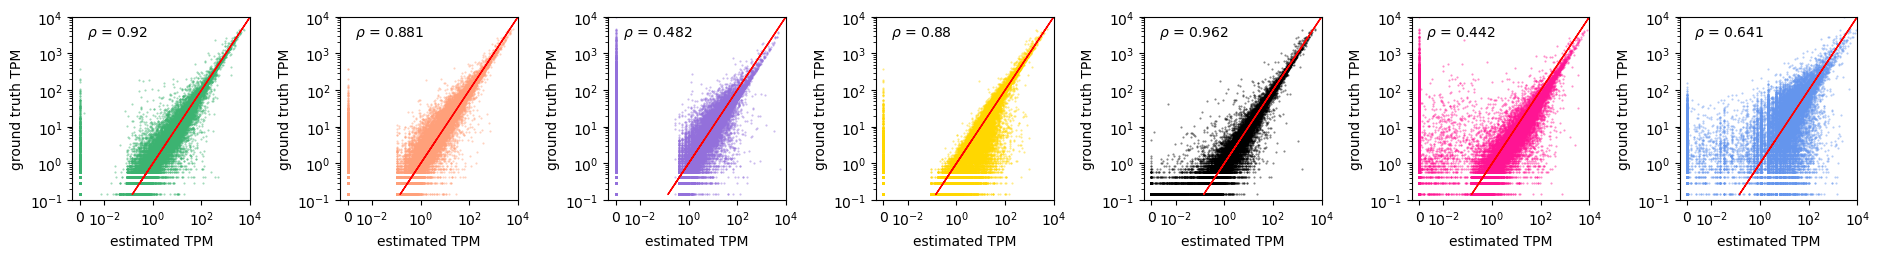

In [11]:
def scatterplot(ref, dfs, n):
    """
    Generates side-by-side scatterplots comparing observed and 
    ground truth TPMs from all tools. 
    'ref': reference dataframe 
    'dfs': list of dataframes made with countsWithIntronIds().
    'n': an integer representing the number of tools being plotted.
    """
    
    # Define figure and panel dimensions
    fig, ax = plt.subplots(1, n, figsize=(2.7 * n, 2.69), tight_layout=True)
    
    countDict = {}
    for df in dfs:
        bigDf = pd.merge(ref, df, how='left', on='intronId').fillna(0)
        colnames = list(bigDf.columns.values)
        sampleName = bigDf.columns[-1]
        name, c, l = colorAndLabel(sampleName)
        for counts in [bigDf[colnames[4]], bigDf[colnames[5]]]:  
            counts = counts.astype(float)            # Convert ground truth & estimated counts to float type.
            counts = (counts / np.sum(counts)) * 1000000            # Re-normalize to TPMs.
        groundTruth = np.array(bigDf[colnames[4]])
        estimated = np.array(bigDf[colnames[5]])
        countDict[name] = [groundTruth, estimated, c]            # Append counts to a dictionary.
    
    countDict = OrderedDict(sorted(countDict.items()))              # Sort count dictionary by keys
    subplotIndex = 0                                                # to index the subplots 
    for program, tpm in countDict.items():                          # by program name, alphabetically.
        groundTruth = tpm[0].copy()
        estimated = tpm[1].copy()
        estimated[estimated <= 0.001] = 0.001                       # Set all estimated values that are
                                                                    # <= 0.001 to 0.001 to show instances of
                                                                    # undetected transcripts at x = 0.001.
        color = tpm[2]
        corr = r'$\rho$ = ' + str(round(stat.spearmanr(tpm[1], tpm[0]).correlation, 3))
        ax[subplotIndex].plot(groundTruth, groundTruth, color='red', lw=1)
        ax[subplotIndex].scatter(estimated, groundTruth, 0.25,
                             c=color,
                             alpha=0.5)
        ax[subplotIndex].text(0.002, 3000, corr)
        ax[subplotIndex].set_xlim(0.0005, 10000)
        ax[subplotIndex].set_ylim(0.1, 10000)
        ax[subplotIndex].set_yscale('log')
        ax[subplotIndex].set_xscale('log')
        ax[subplotIndex].set_xticks([0.001, 0.01, 1, 100, 10000])
        ax[subplotIndex].set_xticklabels(['0', r'$10^{-2}$', r'$10^0$', r'$10^2$', r'$10^4$'])
        ax[subplotIndex].set_xlabel('estimated TPM')
        ax[subplotIndex].set_ylabel('ground truth TPM')
        subplotIndex += 1

scatterplot(refDf, annotatedDfList, 7)

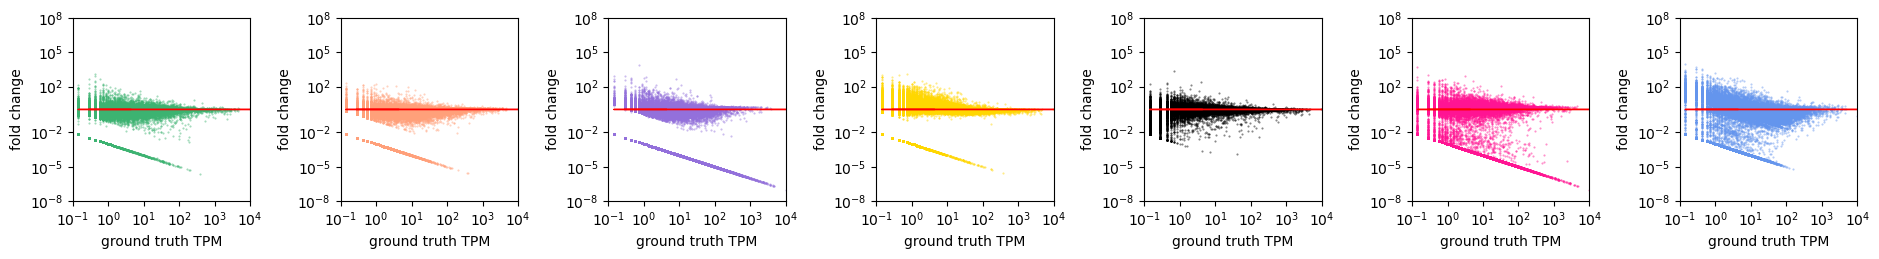

In [12]:
def maplot(ref, dfs, n):
    """
    Generates side-by-side MA plots comparing observed and 
    ground truth TPMs from all tools. 
    'ref': reference dataframe 
    'dfs': list of dataframes made with countsWithIntronIds().
    'n': an integer representing the number of tools being plotted.
    """
    
    # Define figure and panel dimensions
    fig, ax = plt.subplots(1, n, figsize=(2.7 * n, 2.69), tight_layout=True)
    
    countDict = {}
    for df in dfs:
        bigDf = pd.merge(ref, df, how='left', on='intronId').fillna(0)
        colnames = list(bigDf.columns.values)
        sampleName = bigDf.columns[-1]
        name, c, l = colorAndLabel(sampleName)
        for counts in [bigDf[colnames[4]], bigDf[colnames[5]]]:  
            counts = counts.astype(float)            # Convert ground truth & estimated counts to float type.
            counts = (counts / np.sum(counts)) * 1000000            # Re-normalize to TPMs.
        groundTruth = np.array(bigDf[colnames[4]])
        estimated = np.array(bigDf[colnames[5]])
        countDict[name] = [groundTruth, estimated, c]            # Append counts to a dictionary.
    
    countDict = OrderedDict(sorted(countDict.items()))              # Sort count dictionary by keys
    subplotIndex = 0                                                # to index the subplots 
    for program, tpm in countDict.items():                          # by program name, alphabetically.
        groundTruth = tpm[0].copy()
        estimated = tpm[1].copy()
        estimated[estimated <= 0.001] = 0.001                       # Set all estimated values that are
                                                                    # <= 0.001 to 0.001 to show instances of
                                                                    # undetected transcripts at x = 0.001.
        color = tpm[2]
        ax[subplotIndex].plot(groundTruth, groundTruth / groundTruth, color='red', lw=1)
        ax[subplotIndex].scatter(groundTruth, estimated / groundTruth, 0.25,
                             c=color,
                             alpha=0.5)
        ax[subplotIndex].set_xlim(1e-1, 1e4)
        ax[subplotIndex].set_ylim(1e-8, 1e8)
        ax[subplotIndex].set_yscale('log')
        ax[subplotIndex].set_xscale('log')
        ax[subplotIndex].set_yticks([1e-8, 1e-5, 1e-2, 1e2, 1e5, 1e8])
        ax[subplotIndex].set_xticks([1e-1, 1, 1e1, 1e2, 1e3, 1e4])
        ax[subplotIndex].set_xlabel('ground truth TPM')
        ax[subplotIndex].set_ylabel('fold change')
        subplotIndex += 1

maplot(refDf, annotatedDfList, 7)

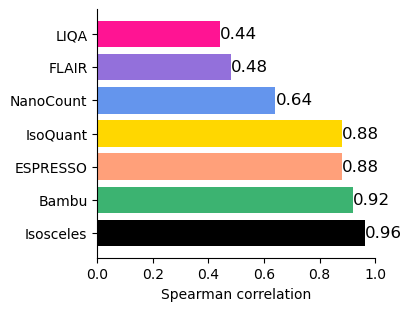

In [13]:
def cor_spearman_barplot(ref, dfs):
    program_names = []
    program_colors = []
    cor_values = []
    for df in dfs:
        program = df.columns[1]
        program_tuple = colorAndLabel(program)
        program_names.append(program_tuple[0])
        program_colors.append(program_tuple[1])
        program_df = pd.merge(ref, df, how='left', on='intronId').fillna(0)        
        cor_values.append(stat.spearmanr(program_df.iloc[:, 4], program_df.iloc[:, 5]).correlation)
    plot_df = pd.DataFrame({
            'name' : program_names,
            'color' : program_colors,
            'cor_value' : cor_values
    })
    plot_df = plot_df.sort_values(by='cor_value', ascending=False)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3), dpi=100, layout='constrained')
    ax.barh(y=plot_df['name'], width=plot_df['cor_value'], color=plot_df['color'])
    ax.set_xlim(0, 1)
    ax.set_xlabel('Spearman correlation')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for bars in ax.containers:
         ax.bar_label(bars, fmt='%.2f', fontsize=12)
    fig.show()

cor_spearman_barplot(refDf, annotatedDfList)

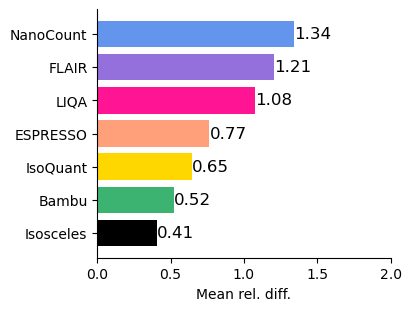

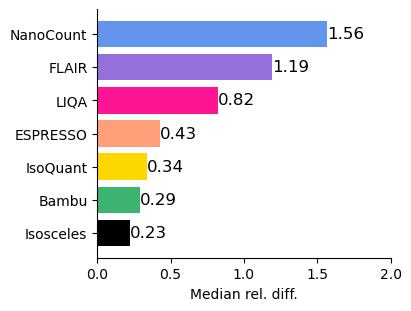

In [14]:
def rel_diff_barplot(ref, dfs, relDiffType):
    program_names = []
    program_colors = []
    rel_diffs = []
    median_rel_diffs = []
    for df in dfs:
        program = df.columns[1]
        program_tuple = colorAndLabel(program)
        program_names.append(program_tuple[0])
        program_colors.append(program_tuple[1])
        program_df = pd.merge(ref, df, how='left', on='intronId').fillna(0)
        rel_diffs.append(relativeDiff(program_df, relDiffType))
        median_rel_diffs.append(relativeDiff(program_df, 'median'))
    plot_df = pd.DataFrame({
            'name' : program_names,
            'color' : program_colors,
            'rel_diff' : rel_diffs,
            'median_rel_diff' : median_rel_diffs
    })
    plot_df = plot_df.sort_values(by='median_rel_diff')
    plot_df = plot_df.drop('median_rel_diff', axis=1)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3), dpi=100, layout='constrained')
    ax.barh(y=plot_df['name'], width=plot_df['rel_diff'], color=plot_df['color'])
    ax.set_xlim(0, 2)
    ax.set_xlabel(relDiffType.title() + ' rel. diff.')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for bars in ax.containers:
         ax.bar_label(bars, fmt='%.2f', fontsize=12)
    fig.show()

rel_diff_barplot(refDf, annotatedDfList, 'mean')
rel_diff_barplot(refDf, annotatedDfList, 'median')

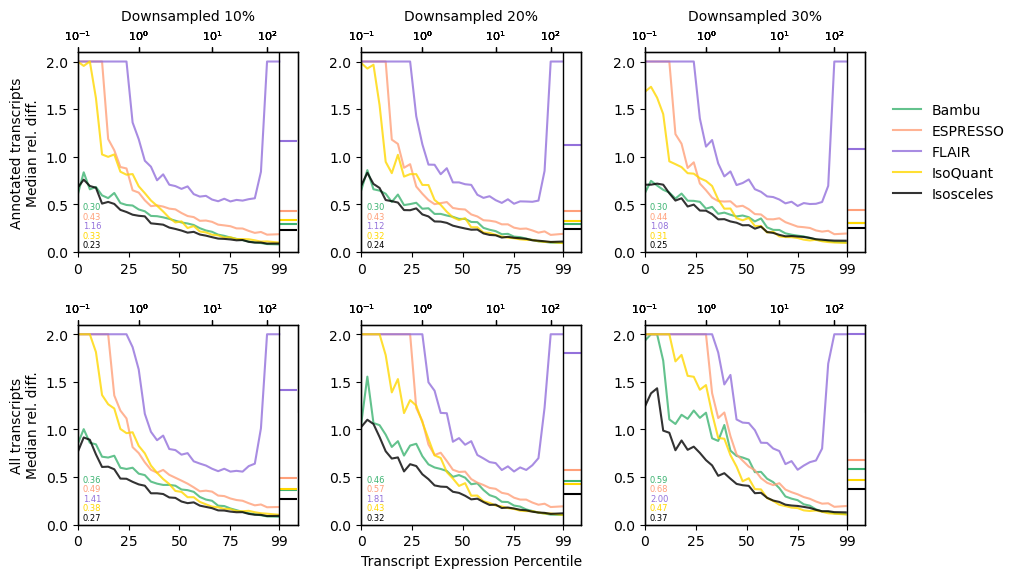

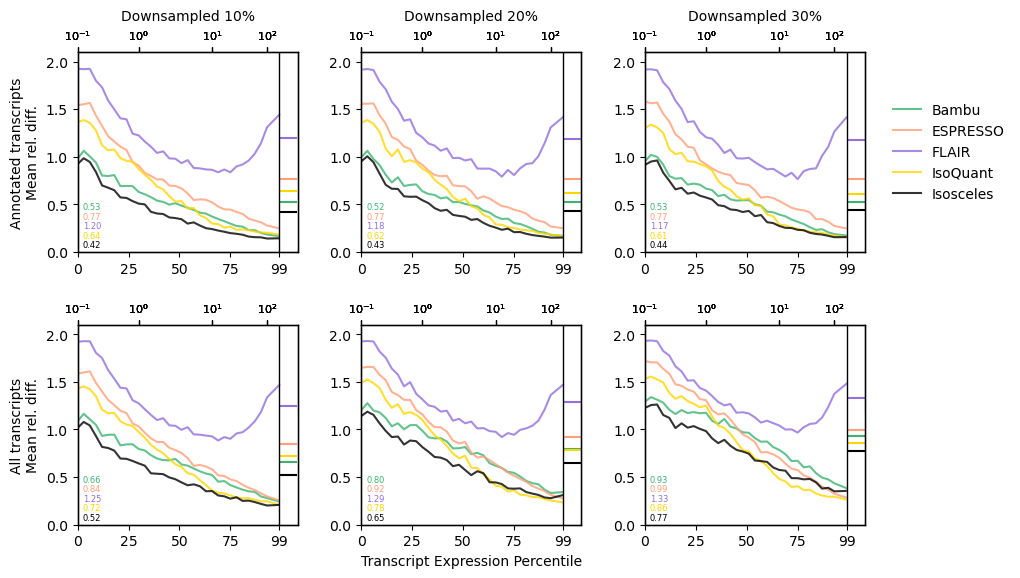

In [15]:
def errorPlot(ref, dfs, n, errorType):
    """
    Plots median relative difference of annotated and
    novel transcript quantification.
    'ref': The reference dataframe of intron string IDs and ground truth counts.
    'dfs': a list of sample dataframes from getFiles().
    'n': an integer representing the number of bins to stratify by.
    """
    
    tickRange = percentileTicks(n)
    
    # Define figure and panel dimensions
    figureWidth = 12
    figureHeight = 6
    panelWidth = 2.2
    panelHeight = 2
    relativePanelWidth = panelWidth / figureWidth
    relativePanelHeight = panelHeight / figureHeight

    # Generate the plot
    plt.figure(figsize=(figureWidth, figureHeight))

    # Plot
    panel1 = plt.axes([1.2 / 11, 6 / 11, relativePanelWidth, relativePanelHeight])

    panel1.set_title(r'Downsampled 10%', fontsize=10.0)
    panel2 = plt.axes([3.8 / 11, 6 / 11, relativePanelWidth, relativePanelHeight])
    panel2.set_title(r'Downsampled 20%', fontsize=10.0)
    panel3 = plt.axes([6.4 / 11, 6 / 11, relativePanelWidth, relativePanelHeight])
    panel3.set_title(r'Downsampled 30%', fontsize=10.0)
    panel4 = plt.axes([1.2 / 11, 1 / 11, relativePanelWidth, relativePanelHeight])
    panel5 = plt.axes([3.8 / 11, 1 / 11, relativePanelWidth, relativePanelHeight])
    panel5.set_xlabel(r'Transcript Expression Percentile', fontsize=10.0)
    panel6 = plt.axes([6.4 / 11, 1 / 11, relativePanelWidth, relativePanelHeight])
    
    panelList = [panel1, panel2, panel3, panel4, panel5, panel6]
    if errorType == 'median':
        # initial height, 'h', and incremental decline, 'j', of error text annotation
        # must be adjusted to fit the number of samples in the comparison and will 
        # be dependent on the y-axis range.
        h = 0.55
        j = 0.10
        panel1.set_ylabel('Annotated transcripts\nMedian rel. diff.', fontsize=10.0)
        panel4.set_ylabel('All transcripts\nMedian rel. diff.', fontsize=10.0)
        for panel in panelList:
            panel.set_xticks([0, 25, 50, 75, 99])
            panel.set_xlim(0, 108)
            panel.set_ylim(0, 2.1)
            panel.vlines(x=99.1, ymin=0, ymax=2.1, color = 'black', linewidth=1, zorder=5)
            rectangle = mplpatches.Rectangle((99.3, 0.05), 107.5 - 99.3, 1.12, color='white', zorder=3)
            panel.add_patch(rectangle)
    elif errorType == 'mean':
        h = 0.55
        j = 0.10
        panel1.set_ylabel('Annotated transcripts\nMean rel. diff.', fontsize=10.0)
        panel4.set_ylabel('All transcripts\nMean rel. diff.', fontsize=10.0)
        for panel in panelList:
            panel.set_xticks([0, 25, 50, 75, 99])
            panel.set_xlim(0, 108)
            panel.set_ylim(0, 2.1)
            panel.vlines(x=99.1, ymin=0, ymax=2.1, color = 'black', linewidth=1, zorder=5)
            rectangle = mplpatches.Rectangle((99.3, 0.05), 107.5 - 99.3, 1.12, color='white', zorder=3)
            panel.add_patch(rectangle)
    else:
        print("Specify 'mean' or 'median' for argument: 'errorType'.")
    
    errorAnnotations = []
    for df in dfs:
        sampleName, error, sidebarError = measureError(ref, df, errorType, n)
        name, c, l = colorAndLabel(sampleName)
        # Assign the sample to its respective panels based on downsample %.
        if '10' in sampleName:
            panels = [panel1, panel4]
        if '20' in sampleName:
            panels = [panel2, panel5]
        if '30' in sampleName:
            panels = [panel3, panel6]
        
        # Plot the error line and sidebar error.
        for i in range(len(panels)):
            panels[i].plot(tickRange, error[i], marker='None', alpha=0.8, 
                            markersize=1, color=c, label=name) 
            panels[i].hlines(y=sidebarError[i], xmin=99.1, xmax=107.9,
                            color = c, linewidth=1.5, zorder=4)
            # Add info for sidebar error value annotation to be added later.
            errorAnnotations.append([int(panelList.index(panels[i])), sampleName, c,
                                                str('{0:.2f}'.format(round(sidebarError[i], 2)))])
            # Add the second x axis
            ax2 = panels[i].twiny()
            ax2.set_xlim(0, 108)
            ax2.set_xticks([0, 30, 66, 93])
            ax2.set_xticklabels(['$10^{-1}$', '$10^0$', '$10^1$', '$10^2$'])
            ax2.tick_params(axis='x', which='major', labelsize=8)

    # Sort the sidebar error value by panel number and sample name.
    errorAnnotations = sorted(errorAnnotations, key=lambda x: (x[0], x[1]))
    # Generate a list of empty lists to determine the height of the error annotations for each panel.
    heights = [[] for _ in range(len(panelList))]
    # Plot the sidebar error value as a text annotation in the bottom left-hand corner.
    for i in range(len(errorAnnotations)):
        panelNumber, label, color, err = errorAnnotations[i]
        heights[panelNumber].append(0)
        panelList[panelNumber].annotate(err, 
                                        (2.5, h - j * len(heights[panelNumber])), 
                                        size=6, color=color)
    
    panel1.legend(loc='center left', bbox_to_anchor=(3.65, 0.5), frameon=False)

errorPlot(refDf, dfList, 33, 'median')
errorPlot(refDf, dfList, 33, 'mean')

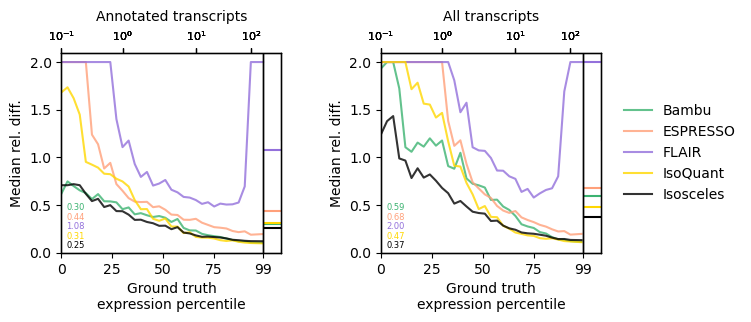

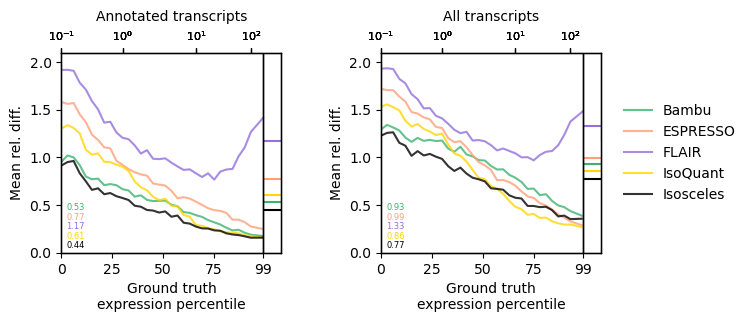

In [16]:
def singleDownsampledErrorPlot(ref, dfs, n, errorType, downsamplePercentage):
    """
    Generates an error plot for one specific downsampled percentage.
    'ref': The reference dataframe of intron string IDs and ground truth counts.
    'dfs': a list of sample dataframes from getFiles().
    'n': an integer representing the number of bins to stratify by.
    'errorType': 'median' or 'mean'.
    'downsamplePercentage': a 2-character integer representing the downsample % of interest.
    """
    
    tickRange = percentileTicks(n)

    figureWidth = 9.5
    figureHeight = 3.3
    panelWidth = 2.2
    panelHeight = 2
    relativePanelWidth = panelWidth / figureWidth
    relativePanelHeight = panelHeight / figureHeight
    plt.figure(figsize=(figureWidth, figureHeight))

    panel1 = plt.axes([0.8 / 11, 2.4 / 11, relativePanelWidth, relativePanelHeight])
    panel1.set_title('Annotated transcripts', fontsize=10.0)
    panel1.set_xlabel('Ground truth\nexpression percentile', fontsize=10.0)
    panel2 = plt.axes([4.5 / 11, 2.4 / 11, relativePanelWidth, relativePanelHeight])
    panel2.set_title('All transcripts', fontsize=10.0)
    panel2.set_xlabel('Ground truth\nexpression percentile', fontsize=10.0)

    for panel in [panel1, panel2]:
        panel.set_xticks([0, 25, 50, 75, 99])
        panel.set_xlim(0, 108)
        panel.set_ylim(0, 2.1)
        panel.vlines(x=99.1, ymin=0, ymax=2.1, color = 'black', linewidth=1, zorder=5)
        rectangle = mplpatches.Rectangle((99.3, 0.05), 107.5 - 99.3, 1.12, color='white', zorder=3)
        panel.add_patch(rectangle)
        
    panelList = [panel1, panel2]
    if errorType == 'median':
        panel1.set_ylabel('Median rel. diff.', fontsize=10.0)
        panel2.set_ylabel('Median rel. diff.', fontsize=10.0)
        for panel in panelList:
            panel.set_xticks([0, 25, 50, 75, 99])
            panel.set_xlim(0, 108)
            panel.set_ylim(0, 2.1)
            panel.vlines(x=99.1, ymin=0, ymax=2.1, color = 'black', linewidth=1, zorder=5)
            rectangle = mplpatches.Rectangle((99.3, 0.05), 107.5 - 99.3, 1.12, color='white', zorder=3)
            panel.add_patch(rectangle)
    elif errorType == 'mean':
        panel1.set_ylabel('Mean rel. diff.', fontsize=10.0)
        panel2.set_ylabel('Mean rel. diff.', fontsize=10.0)
        for panel in panelList:
            panel.set_xticks([0, 25, 50, 75, 99])
            panel.set_xlim(0, 108)
            panel.set_ylim(0, 2.1)
            panel.vlines(x=99.1, ymin=0, ymax=2.1, color = 'black', linewidth=1, zorder=5)
            rectangle = mplpatches.Rectangle((99.3, 0.05), 107.5 - 99.3, 1.12, color='white', zorder=3)
            panel.add_patch(rectangle)
    else:
        print("Specify 'mean' or 'median' for argument: 'errorType'.")
    
    errorAnnotations = []
    for df in dfs:
        sampleName, error, sidebarError = measureError(ref, df, errorType, n)
        name, c, l = colorAndLabel(sampleName)
        # Assign the sample to its respective panels based on downsample %.
        if str(downsamplePercentage) in sampleName:
            panels = [panel1, panel2]
        else:
            continue
        
        # Plot the error line and sidebar error.
        for i in range(len(panels)):
            panels[i].plot(tickRange, error[i], marker='None', alpha=0.8, 
                            markersize=1, color=c, label=name) 
            panels[i].hlines(y=sidebarError[i], xmin=99.1, xmax=107.9,
                            color = c, linewidth=1.5, zorder=4)
            # Add info for sidebar error value annotation to be added later.
            errorAnnotations.append([int(panelList.index(panels[i])), sampleName, c,
                                                str('{0:.2f}'.format(round(sidebarError[i], 2)))])
            # Add the second x axis
            ax2 = panels[i].twiny()
            ax2.set_xlim(0, 108)
            ax2.set_xticks([0, 30, 66, 93])
            ax2.set_xticklabels(['$10^{-1}$', '$10^0$', '$10^1$', '$10^2$'])
            ax2.tick_params(axis='x', which='major', labelsize=8)

    # Sort the sidebar error value by panel number and sample name.
    errorAnnotations = sorted(errorAnnotations, key=lambda x: (x[0], x[1]))
    # Generate a list of empty lists to determine the height of the error annotations for each panel.
    heights = [[] for _ in range(len(panelList))]
    # initial height, 'h', and incremental decline, 'j', must be adjusted to fit the number of
    # samples in the comparison and will be dependent on the y-axis range.
    if errorType == 'median':
        h = 0.55
        j = 0.10
    elif errorType == 'mean':
        h = 0.55
        j = 0.10
    # Plot the sidebar error value as a text annotation in the bottom left-hand corner.
    for i in range(len(errorAnnotations)):
        panelNumber, label, color, err = errorAnnotations[i]
        heights[panelNumber].append(0)
        panelList[panelNumber].annotate(err, 
                                        (2.5, h - j * len(heights[panelNumber])), 
                                        size=6, color=color)
    
    panel1.legend(loc='center left', bbox_to_anchor=(2.5, 0.5), frameon=False)
    
singleDownsampledErrorPlot(refDf, dfList, 33, 'median', 30)
singleDownsampledErrorPlot(refDf, dfList, 33, 'mean', 30)

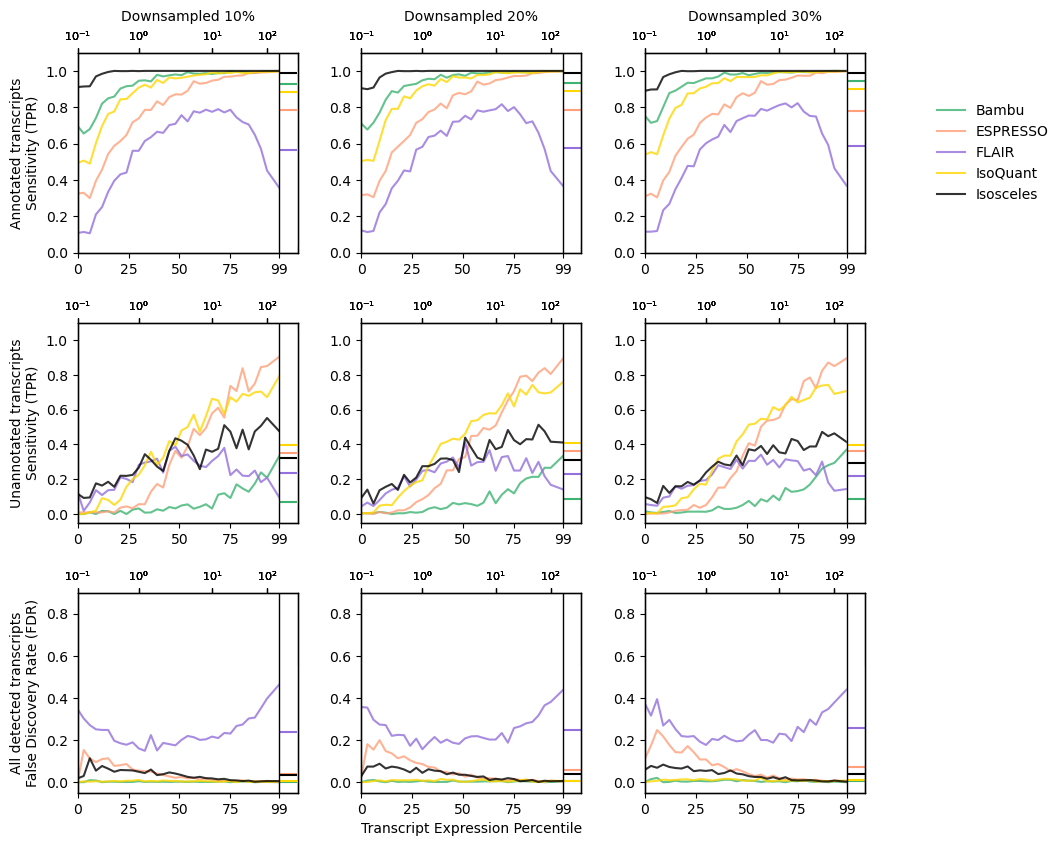

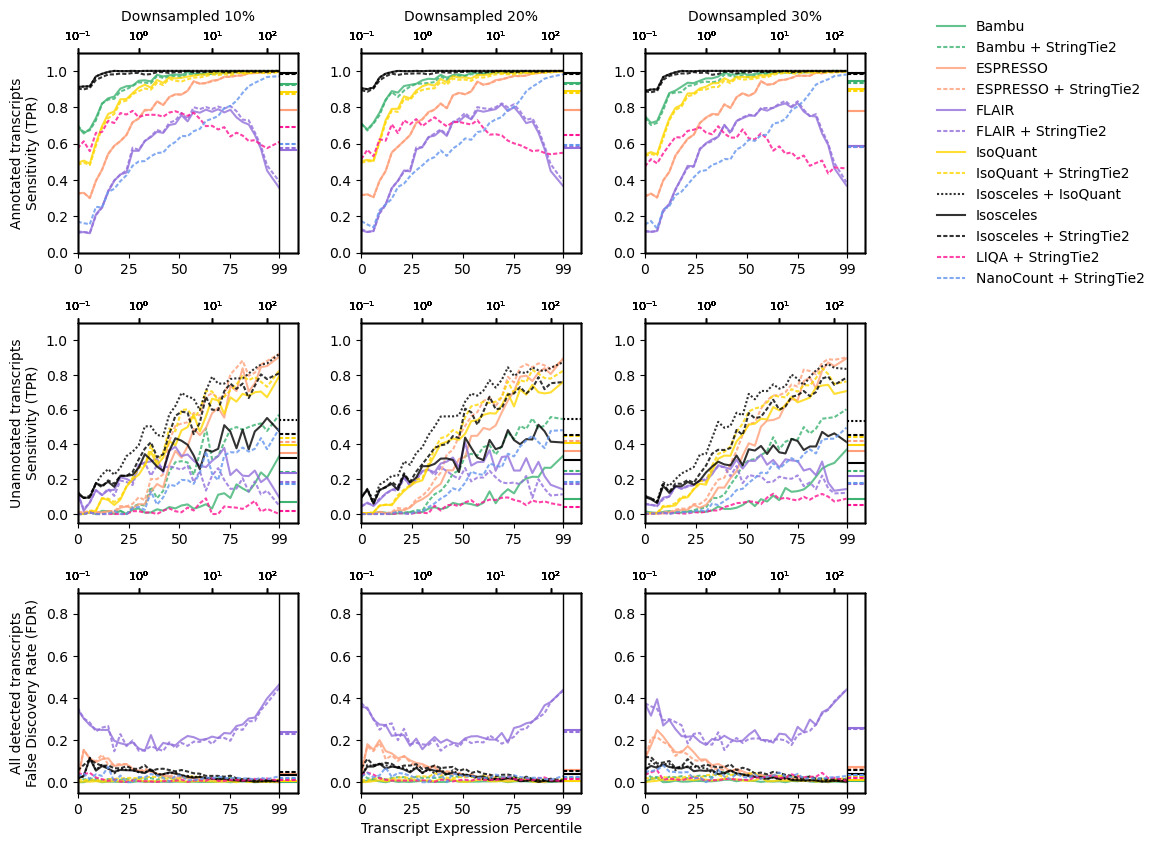

In [17]:
def sensitivityPlot(ref, dfs, n):
    """
    Generates sensitivity plots for downsampled data.
    'ref': a pandas dataframe of reference transcript IDs and ground truth counts.
    'dfs': a list of pandas dataframes of counts.
    'n': an integer representing the number of bins out of 99 to stratify by.
    """

    tickRange = percentileTicks(n)

    figureWidth = 12
    figureHeight = 9
    panelWidth = 2.2
    panelHeight = 2
    relativePanelWidth = panelWidth / figureWidth
    relativePanelHeight = panelHeight / figureHeight
    plt.figure(figsize=(figureWidth, figureHeight))
    
    panel1 = plt.axes([1.2 / 11, 7.6 / 11, relativePanelWidth, relativePanelHeight])
    panel1.set_ylabel('Annotated transcripts\nSensitivity (TPR)', fontsize=10.0)
    panel1.set_title('Downsampled 10%', fontsize=10.0)
    panel2 = plt.axes([1.2 / 11, 4.3 / 11, relativePanelWidth, relativePanelHeight])
    panel2.set_ylabel('Unannotated transcripts\nSensitivity (TPR)', fontsize=10.0)
    panel3 = plt.axes([1.2 / 11, 1.0 / 11, relativePanelWidth, relativePanelHeight])
    panel3.set_ylabel('All detected transcripts\nFalse Discovery Rate (FDR)', fontsize=10.0)
    panel4 = plt.axes([3.8 / 11, 7.6 / 11, relativePanelWidth, relativePanelHeight])
    panel4.set_title('Downsampled 20%', fontsize=10.0)
    panel5 = plt.axes([3.8 / 11, 4.3 / 11, relativePanelWidth, relativePanelHeight])
    panel6 = plt.axes([3.8 / 11, 1.0 / 11, relativePanelWidth, relativePanelHeight])
    panel6.set_xlabel(r'Transcript Expression Percentile', fontsize=10.0)
    panel7 = plt.axes([6.4 / 11, 7.6 / 11, relativePanelWidth, relativePanelHeight])
    panel7.set_title('Downsampled 30%', fontsize=10.0)
    panel8 = plt.axes([6.4 / 11, 4.3 / 11, relativePanelWidth, relativePanelHeight])
    panel9 = plt.axes([6.4 / 11, 1.0 / 11, relativePanelWidth, relativePanelHeight])
    
    for panel in [panel1, panel2, panel3, panel4, panel5,
                 panel6, panel7, panel8, panel9]:
        panel.set_xticks([0, 25, 50, 75, 99])
        panel.set_xlim(0, 108)
    
    for panel in [panel1, panel4, panel7]:
        panel.set_ylim(0.0, 1.1)
        panel.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        panel.vlines(x=99.1, ymin=-1, ymax=1.1, 
                     color='black', linewidth=1, zorder=5)
        rectangle = mplpatches.Rectangle((99.3, 0.05), 8.2, 1, color='white', zorder=3)
        panel.add_patch(rectangle)
    for panel in [panel2, panel5, panel8]:
        panel.set_ylim(-0.05, 1.1)
        panel.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        panel.vlines(x=99.1, ymin=-1, ymax=1.1, 
                     color='black', linewidth=1, zorder=5)
        rectangle = mplpatches.Rectangle((99.3, 0.05), 8.2, 1, color='white', zorder=3)
        panel.add_patch(rectangle)
    for panel in [panel3, panel6, panel9]:
        panel.set_ylim(-0.05, 0.9)
        panel.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
        panel.vlines(x=99.1, ymin=-1, ymax=1.1, 
                     color='black', linewidth=1, zorder=5)
        rectangle = mplpatches.Rectangle((99.3, 0.05), 8.2, 0.5, color='white', zorder=3)
        panel.add_patch(rectangle)
    
    for df in dfs:
        statistics, meanStats, downCol, sampleName = measureDeNovoDetection(ref, df, n)
        name, c, l = colorAndLabel(sampleName)
        if '10' in downCol:
            panels = [panel1, panel2, panel3]
        if '20' in downCol:
            panels = [panel4, panel5, panel6]
        if '30' in downCol:
            panels = [panel7, panel8, panel9]

        for i in range(len(panels)):
            panels[i].plot(tickRange, statistics[i], marker='None', alpha=0.8, 
                           markersize=1, color=c, linestyle = l, label=name)
            panels[i].hlines(y=meanStats[i], xmin=99.1, xmax=107.9,
                             color = c, linestyle = l, linewidth=1.5, zorder=4)
            # Add the second x axis
            ax2 = panels[i].twiny()
            ax2.set_xlim(0, 108)
            ax2.set_xticks([0, 30, 66, 93])
            ax2.set_xticklabels(['$10^{-1}$', '$10^0$', '$10^1$', '$10^2$'])
            ax2.tick_params(axis='x', which='major', labelsize=8)

    panel1.legend(loc='center left', bbox_to_anchor=(3.85, 0.5), frameon=False)

sensitivityPlot(refDf, dfList, 33)
sensitivityPlot(refDf, stringtieDfList, 33)

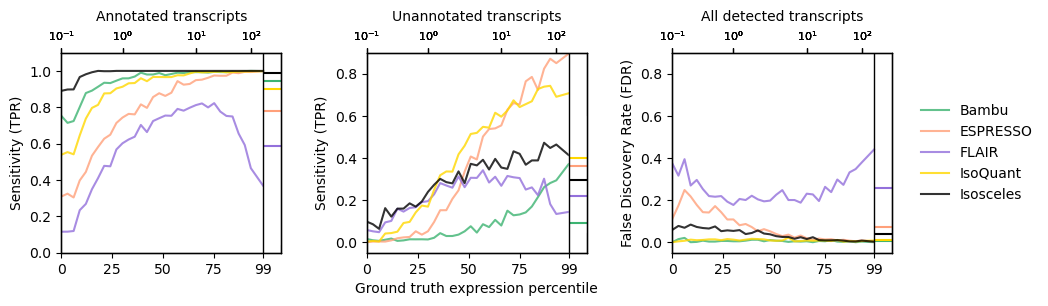

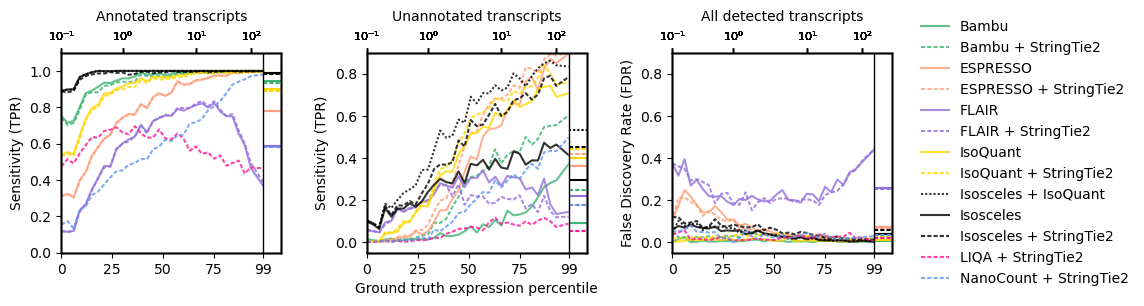

In [18]:
def singleDownsampledSensitivityPlot(ref, dfs, n, downsamplePercentage):
    """
    Generates an error plot for one specific downsampled percentage.
    'ref': The reference dataframe of intron string IDs and ground truth counts.
    'dfs': a list of sample dataframes from getFiles().
    'n': an integer representing the number of bins to stratify by.
    'downsamplePercentage': a 2-character integer representing the downsample % of interest.
    """
    
    tickRange = percentileTicks(n)
    
    figureWidth = 12
    figureHeight = 3
    panelWidth = 2.2
    panelHeight = 2
    relativePanelWidth = panelWidth / figureWidth
    relativePanelHeight = panelHeight / figureHeight
    plt.figure(figsize=(figureWidth, figureHeight))

    panel1 = plt.axes([0.6 / 11, 1.8 / 11, relativePanelWidth, relativePanelHeight])
    panel1.set_ylim(0.0, 1.1)
    panel1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    rectangle = mplpatches.Rectangle((99.3, 0.05), 8.2, 0.9, color='white', zorder=3)
    panel1.add_patch(rectangle)
    panel1.set_title('Annotated transcripts', fontsize=10.0)
    panel1.set_ylabel('Sensitivity (TPR)', fontsize=10.0)
    panel2 = plt.axes([3.4 / 11, 1.8 / 11, relativePanelWidth, relativePanelHeight])
    panel2.set_title('Unannotated transcripts', fontsize=10.0)
    panel2.set_ylabel('Sensitivity (TPR)', fontsize=10.0)
    panel2.set_xlabel(r'Ground truth expression percentile', fontsize=10.0)
    panel2.set_ylim(-0.05, 0.9)
    panel2.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
    rectangle = mplpatches.Rectangle((99.3, 0.05), 8.2, 0.55, color='white', zorder=3)
    panel2.add_patch(rectangle)
    panel3 = plt.axes([6.2 / 11, 1.8 / 11, relativePanelWidth, relativePanelHeight])
    panel3.set_title('All detected transcripts', fontsize=10.0)
    panel3.set_ylabel('False Discovery Rate (FDR)', fontsize=10.0)
    panel3.set_ylim(-0.05, 0.9)
    panel3.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
    rectangle = mplpatches.Rectangle((99.3, 0.05), 8.2, 0.5, color='white', zorder=3)
    panel1.add_patch(rectangle)

    for panel in [panel1, panel2, panel3]:
        panel.set_xlim(0, 108)
        panel.set_xticks([0, 25, 50, 75, 99])
        panel.vlines(x=99.1, ymin=-1, ymax=1.1, 
                     color='black', linewidth=1, zorder=5)
    
    for df in dfs:
        statistics, meanStats, downCol, sampleName = measureDeNovoDetection(ref, df, n)
        name, c, l = colorAndLabel(sampleName)
        if str(downsamplePercentage) in sampleName:
            panels = [panel1, panel2, panel3]
        else:
            continue
        
        # Plot the error line and sidebar error.
        for i in range(len(panels)):
            panels[i].plot(tickRange, statistics[i], marker='None', alpha=0.8, 
                           markersize=1, color=c, linestyle = l, label=name)
            panels[i].hlines(y=meanStats[i], xmin=99.1, xmax=107.9,
                             color = c, linestyle = l, linewidth=1.5, zorder=4)
            # Add the second x axis
            ax2 = panels[i].twiny()
            ax2.set_xlim(0, 108)
            ax2.set_xticks([0, 30, 66, 93])
            ax2.set_xticklabels(['$10^{-1}$', '$10^0$', '$10^1$', '$10^2$'])
            ax2.tick_params(axis='x', which='major', labelsize=8)
    
    panel1.legend(loc='center left', bbox_to_anchor=(3.85, 0.5), frameon=False)

singleDownsampledSensitivityPlot(refDf, dfList, 33, 30)
singleDownsampledSensitivityPlot(refDf, stringtieDfList, 33, 30)

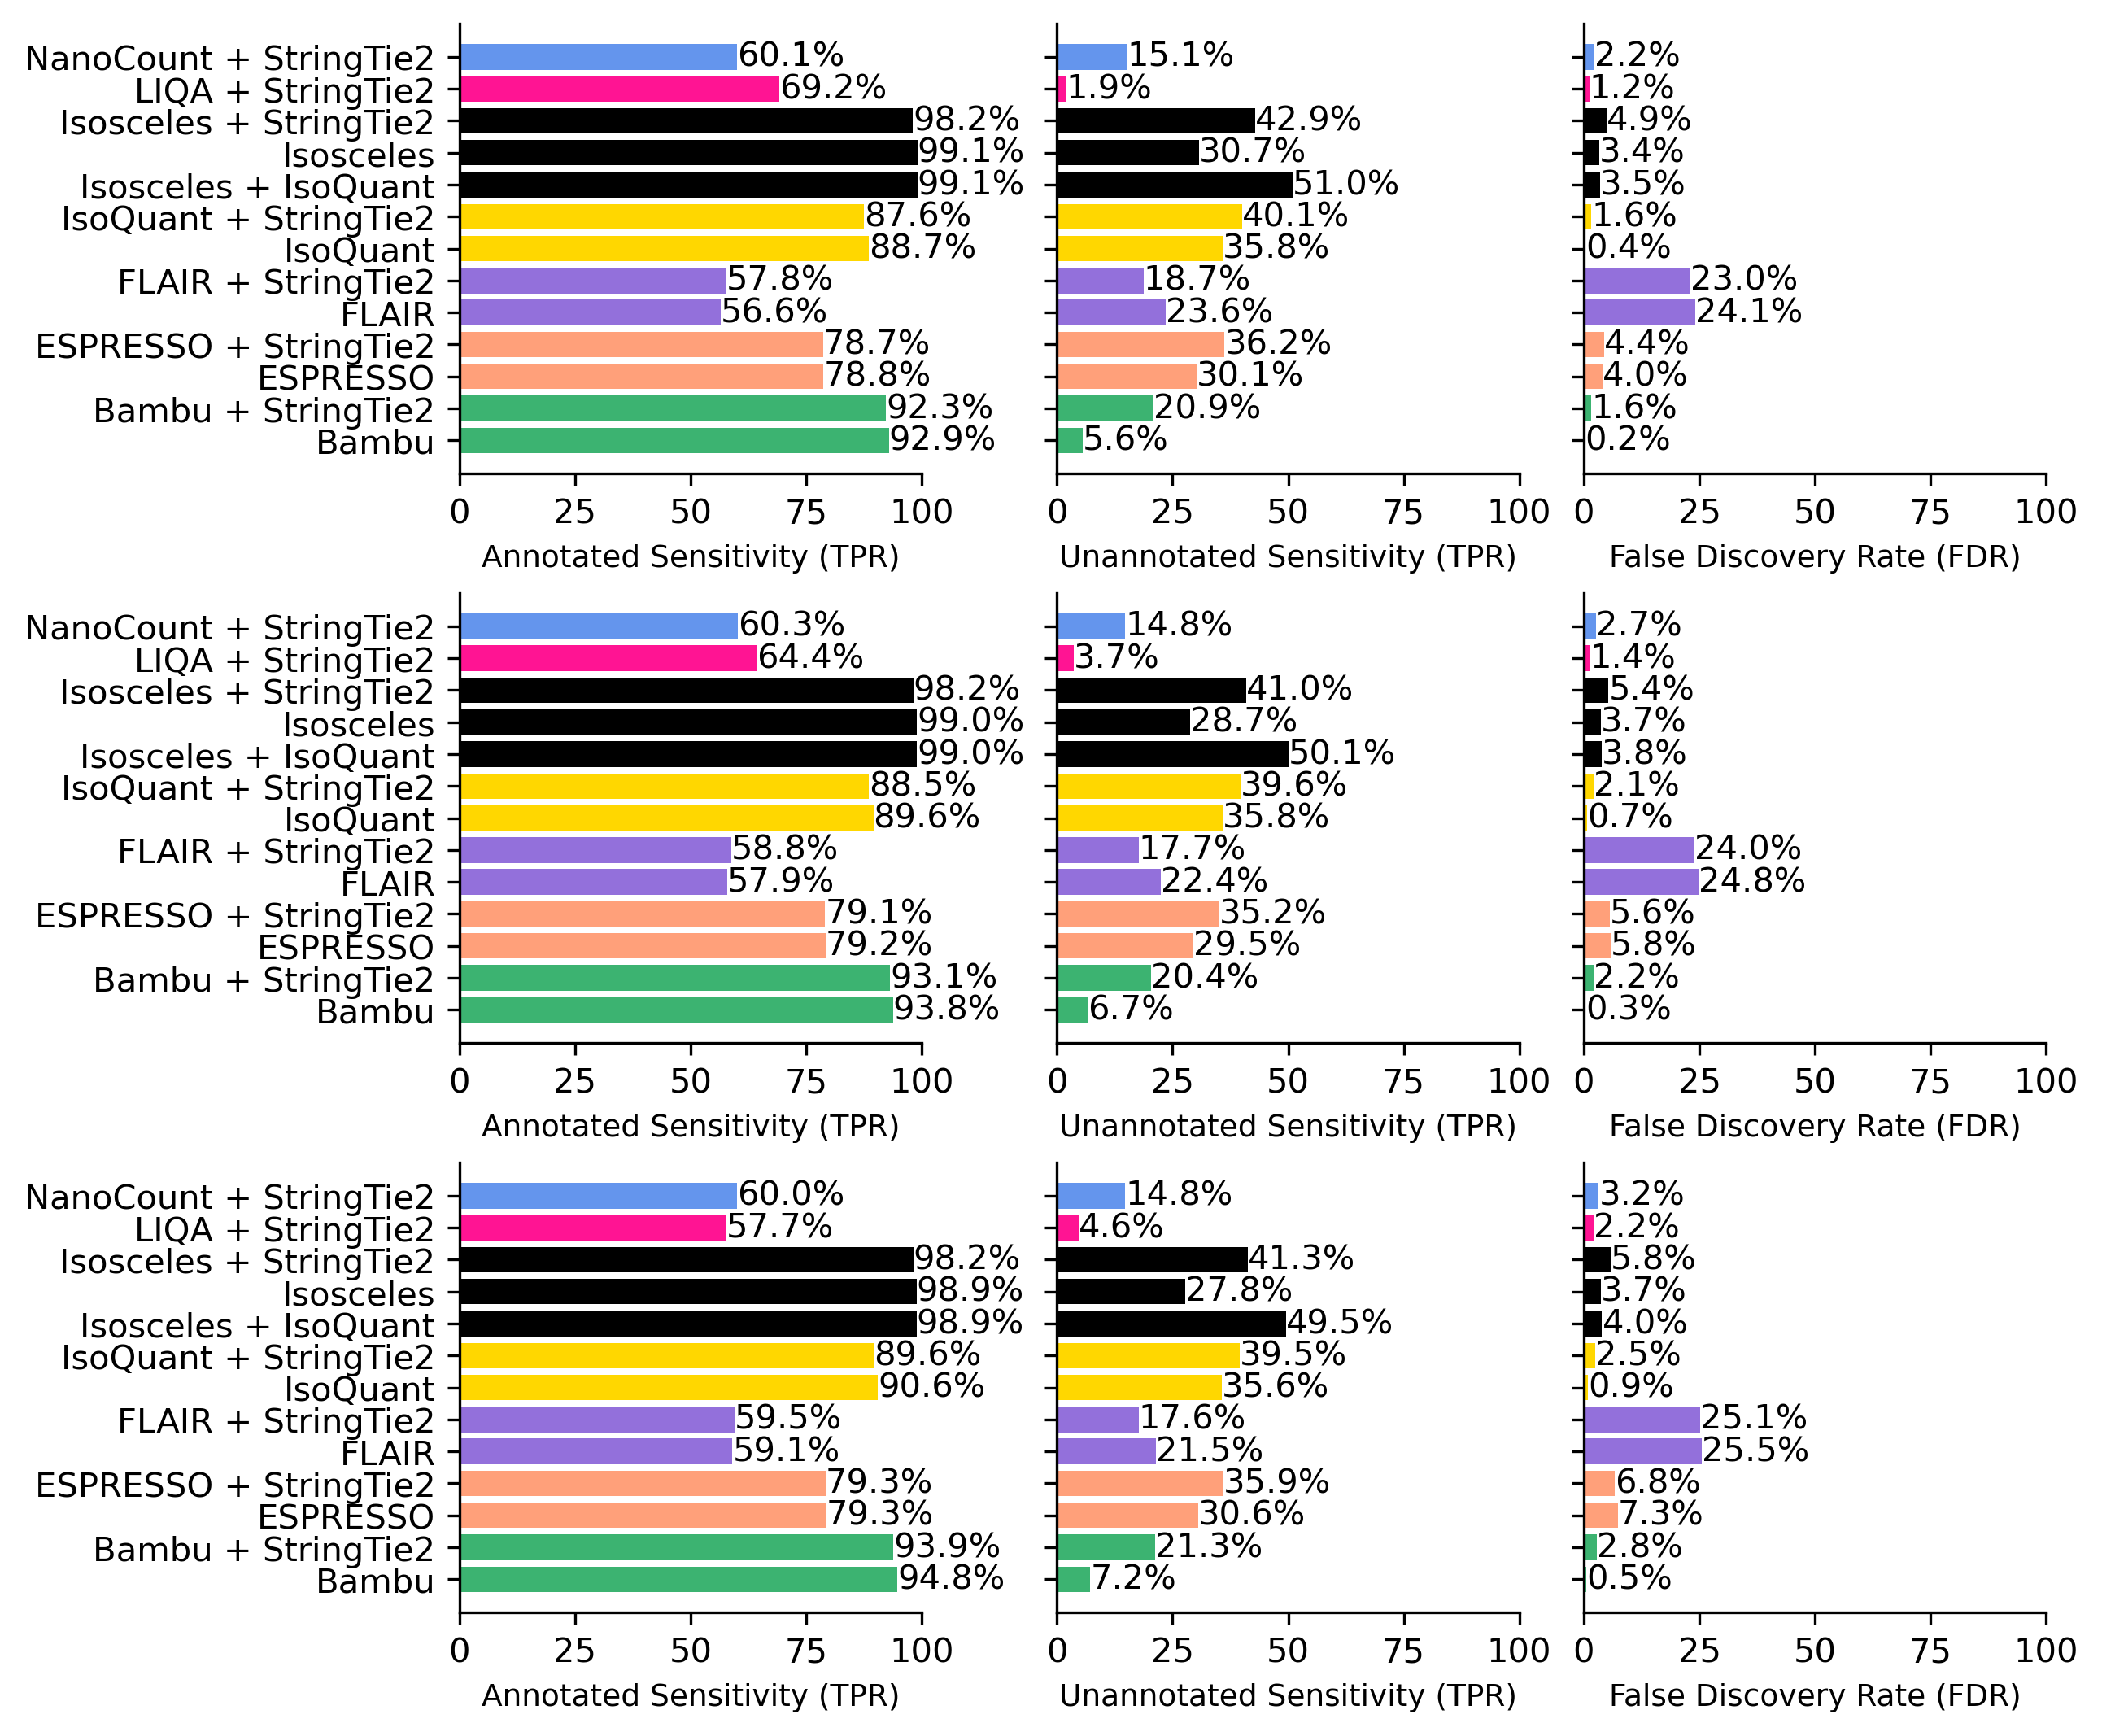

In [19]:
def sensitivityStatBarPlot(ref, dfs, n):
    """
    Generates sensitivity statistics bar plots for downsampled data.
    'ref': a pandas dataframe of reference transcript IDs and ground truth counts.
    'dfs': a list of pandas dataframes of counts.
    'n': an integer representing the number of bins out of 99 to stratify by.
    """

    df_data = []
    for df in dfs:
        bigDf, downCol, sampleName = prepareBinnedData(ref, df, n)
        colnames = list(bigDf.columns.values)
        groundTruth = colnames[4]
        estimated = colnames[5]
        knownDf = bigDf[(bigDf[downCol] == 1) & (bigDf[groundTruth] > 0)].copy()  
        novelDf = bigDf[(bigDf[downCol] == 0) & (bigDf[groundTruth] > 0)].copy()  
        detectedDf = bigDf[bigDf[estimated] > 0].iloc[:, :6].copy()
        detectedDf = detectedDf.sort_values(by=[estimated])
        detectedDf['quantile'] = pd.qcut(detectedDf[estimated].rank(method='first'), q = n, labels = False)
        program, condition = sampleName.split('_down')
        name, color, line = colorAndLabel(program)
        opacity = 1.0
        if ('stringtie' in sampleName) or ('IsoQuant' in sampleName):
            opacity = 0.7
        df_data.append((name, color, line, opacity, program, condition, 'knownTPR', sensitivity(knownDf)))
        df_data.append((name, color, line, opacity, program, condition, 'novelTPR', sensitivity(novelDf)))
        df_data.append((name, color, line, opacity, program, condition, 'novelFDR', fdr(detectedDf)))
    df = pd.DataFrame(df_data, columns=['Name', 'Color', 'Line', 'Opacity', 'Program', 'Condition', 'Metric', 'Value'])

    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(8.5, 7), dpi=300,
                        layout="constrained", sharey=True)
    down = ["10", "20", "30"]
    tpr  = ["knownTPR", "novelTPR", "novelFDR"]
    for i in range(3):
        ndf = df[df['Condition'] == down[i]]
        for j in range(3):
            plt_df = ndf[ndf['Metric'] == tpr[j]]
            plt_df['Value'] *= 100
            axs[i,j].barh(y=plt_df['Name'], width=plt_df['Value'], color=plt_df['Color'])
            axs[i,j].set_xlim(0, 100)
            axs[i,j].spines['right'].set_visible(False)
            axs[i,j].spines['top'].set_visible(False)
            var = tpr[j].replace("known", "Annotated ").replace("novelFDR", "FDR").replace("novel", "Unannotated ")
            var = var.replace("FDR", "False Discovery Rate (FDR)").replace("TPR", "Sensitivity (TPR)")
            axs[i,j].set_xlabel(var, fontsize=9)
            for bars in axs[i,j].containers:
                axs[i,j].bar_label(bars, fmt='%.1f%%')

sensitivityStatBarPlot(refDf, stringtieDfList, 33)